### 1、数据处理

In [1]:
import torchvision.transforms as transforms
from xy_dataset_addStop import XYDataset

TRANSFORMS = transforms.Compose([      
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#分为自动收集和手动收集两个数据集，需要更多不同场景时，需要重新添加另外搞个数据集，不能混在一起
TASK = 'racing'
CATEGORIES = ['test_5M_2R_1L_1S']
DATASETS = ['AutoCollect']
datasets = {}
for name in DATASETS:
    datasets[name] = XYDataset(TASK + '_' + name, CATEGORIES, TRANSFORMS, random_hflip=True)

#初始化数据集
dataset = datasets[DATASETS[0]]

### 2、控件定义

In [2]:
import cv2
import ipywidgets 
import traitlets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

In [3]:
import torch
import torchvision

device = torch.device('cuda')
output_dim = 7  #已增加停车

# 模型
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)

model = model.to(device)

model_save_button = ipywidgets.Button(description='save model')
model_load_button = ipywidgets.Button(description='load model')
model_path_widget = ipywidgets.Text(description='model path', value='./Models/resnet_5M_2R_1L_1S.pth')

def load_model(c):
    model.load_state_dict(torch.load(model_path_widget.value))
model_load_button.on_click(load_model)
    
def save_model(c):
    torch.save(model.state_dict(), model_path_widget.value)
model_save_button.on_click(save_model)

model_widget = ipywidgets.VBox([
    model_path_widget,
    ipywidgets.HBox([model_load_button, model_save_button])
])

display(model_widget)

In [4]:
import time
print(1)
BATCH_SIZE = 8

loss_store = []
optimizer = torch.optim.Adam(model.parameters())

epochs_widget = ipywidgets.IntText(description='epochs', value=10)
eval_button = ipywidgets.Button(description='evaluate')
train_button = ipywidgets.Button(description='train')
loss_widget = ipywidgets.FloatText(description='loss')
progress_widget = ipywidgets.FloatProgress(min=0.0, max=1.0, description='progress')

def train_eval(is_training):
    global BATCH_SIZE, LEARNING_RATE, MOMENTUM, model, dataset, optimizer, eval_button, train_button, accuracy_widget, loss_widget, progress_widget, state_widget
    
    try:
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        train_button.disabled = True
        eval_button.disabled = True
        time.sleep(1)

        if is_training:
            model = model.train()
        else:
            model = model.eval()

        while epochs_widget.value > 0:
            i = 0
            sum_loss = 0.0
            error_count = 0.0
            for images, category_idx, xy in iter(train_loader):
                # send data to device
                images = images.to(device)
                xy = xy.to(device)

                if is_training:
                    # zero gradients of parameters
                    optimizer.zero_grad()

                # execute model to get outputs
                outputs = model(images)

                # compute MSE loss over x, y coordinates for associated categories
                loss = 0.0
                for batch_idx, cat_idx in enumerate(list(category_idx.flatten())):
                    loss += torch.mean((outputs[batch_idx][7 * cat_idx:7 * cat_idx+7] - xy[batch_idx])**2)
                loss /= len(category_idx)

                if is_training:
                    # run backpropogation to accumulate gradients
                    loss.backward()

                    # step optimizer to adjust parameters
                    optimizer.step()

                # increment progress
                count = len(category_idx.flatten())
                i += count
                sum_loss += float(loss)
                progress_widget.value = i / len(dataset)
                loss_widget.value = sum_loss / i
                loss_store.append(loss_widget.value)
                
                
            if is_training:
                epochs_widget.value = epochs_widget.value - 1
            else:
                break
    except:
        pass
    model = model.eval()

    train_button.disabled = False
    eval_button.disabled = False
    
train_button.on_click(lambda c: train_eval(is_training=True))
eval_button.on_click(lambda c: train_eval(is_training=False))
    
train_eval_widget = ipywidgets.VBox([
    epochs_widget,
    progress_widget,
    loss_widget,
    ipywidgets.HBox([train_button, eval_button])
])

display(train_eval_widget)
display(model_widget)


1


### TRT优化

In [11]:
import torch
import torchvision
from torch2trt import torch2trt

device = torch.device('cuda')
model1 = torchvision.models.resnet18(pretrained=False)
model1.fc = torch.nn.Linear(512, 7)
model1 = model1.cuda().eval().half()
model1.load_state_dict(torch.load('./Models/resnet_5M_2R_1L_1S.pth'))

data = torch.zeros((1, 3, 224, 224)).cuda().half()
model_trt = torch2trt(model1, [data], fp16_mode=True)
torch.save(model_trt.state_dict(), './Models/resnet_5M_2R_1L_1S_trt.pth')

FileNotFoundError: [Errno 2] No such file or directory: './Models/resnet_5M_2R_1L_1S.pth'

In [5]:
#模型推理速度计算
from utils import preprocess
import numpy as np

from time import * 
begin_time = time()
train_loader1 = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True
)
for image, _, _ in iter(train_loader1):
    image = image.to(device)
    output = model(image)
    break

# image = preprocess(np.array(image))
# output = model(preprocess(torch.tensor(list(image)).numpy())).detach().cpu().numpy().flatten()
# x = float(output[0])
               
end_time = time()
inference_time = end_time - begin_time
print(inference_time)

58.2743444442749


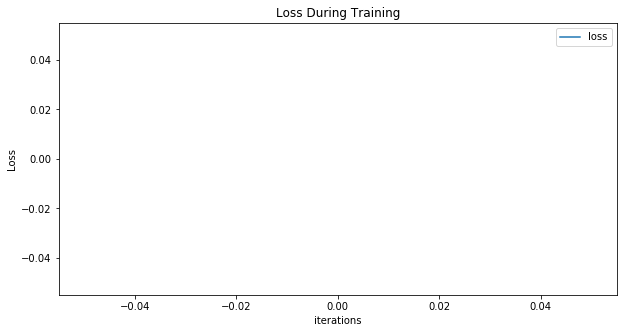

In [6]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(loss_store,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
from FilesWeNeed.csi_camera import CSICamera
camera = CSICamera(width=224, height=224, capture_fps=30)

ModuleNotFoundError: No module named 'FilesWeNeed'

In [15]:
import threading
import time
from utils import preprocess
import torch.nn.functional as F

state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
prediction_widget = ipywidgets.Image(format='jpeg', width=camera.width, height=camera.height)
prediction_x_widget = ipywidgets.FloatText(description='prediction_x') # liu

def live(state_widget, model, camera, prediction_widget):
    global dataset
    while state_widget.value == 'live':
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed).detach().cpu().numpy().flatten()
        category_index = dataset.categories.index(category_widget.value)
        
        x = output[2 * category_index]
        y = output[2 * category_index + 1]
        
        prediction_x_widget.value = x # liu
       
        x = int(camera.width * (x / 2.0 + 0.5))
        y = int(camera.height * (y / 2.0 + 0.5))
        prediction_x_array.append(x) # wky add: appending the prediction_x_array
        
        
        prediction = image.copy()
        prediction = cv2.circle(prediction, (x, y), 8, (255, 0, 0), 3)
        prediction_widget.value = bgr8_to_jpeg(prediction)
            
def start_live(change):
    if change['new'] == 'live':
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget))
        execute_thread.start()
        
def to_predict(image):
    global dataset
    

state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    prediction_widget,
    state_widget,
    prediction_x_widget
])

display(live_execution_widget)

ModuleNotFoundError: No module named 'utils'

In [12]:
import os
import numpy as np
import cv2

def predict(image, model, prediction_x_array):
    preprocessed = preprocess(image)
    output = model(preprocessed).detach().cpu().numpy().flatten()
    xvv = []
    for i in range(0, len(output)):
        x_value = int(224 * (output[i] / 2.0 + 0.5))
        xvv.append(x_value)
    return xvv
#     x_value = prediction_x_widget.value
#     prediction_x_array.append(x_value)

prediction_x_array = [] # saving the predicted x-values
path = '/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture'
os.chdir(path)
predicted_list = os.listdir('.')
a = len(predicted_list)
x_values = []
for i in range(0, a):
    photo_path = path + '/' + predicted_list[i]
    print(photo_path)
    image = cv2.imread(photo_path)
    x_values.append(predict(image, model, prediction_x_array))

/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/123_56_405_ff42ab46-1eb0-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/26_104_336_d9e87a92-1eb0-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/215_100_830_edc96ed0-1eb1-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/86_74_1697_aba238c8-1eb3-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/103_62_532_41ac9aa0-1eb1-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/119_62_1183_c2210bc0-1eb2-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/121_62_1275_ecdcbff8-1eb2-11ec-a343-845cf326e67a.jpg
/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture/167_76_475_2307a7

In [11]:
print(x_values)

[[136, 139, 41, 165, 189, 306, 92], [139, 137, 31, 154, 186, 303, 97], [137, 141, 35, 160, 187, 308, 91], [137, 138, 31, 157, 184, 303, 98], [139, 142, 34, 156, 186, 301, 93], [139, 141, 33, 158, 187, 302, 93], [141, 138, 39, 153, 181, 298, 93], [140, 144, 31, 155, 189, 306, 90], [142, 143, 33, 158, 181, 307, 91], [140, 140, 37, 160, 185, 303, 90], [134, 140, 37, 156, 190, 305, 94], [137, 135, 33, 156, 186, 306, 91], [147, 139, 34, 159, 188, 299, 89], [136, 138, 37, 158, 185, 306, 93], [139, 137, 33, 161, 184, 304, 95], [137, 139, 36, 159, 184, 304, 94], [134, 139, 35, 164, 189, 299, 91], [141, 139, 31, 157, 184, 307, 88], [139, 142, 39, 161, 189, 304, 89], [138, 142, 30, 159, 188, 301, 95], [139, 138, 33, 158, 188, 298, 97], [140, 137, 34, 154, 183, 300, 94], [136, 143, 33, 162, 184, 303, 94], [142, 142, 34, 156, 184, 303, 97], [138, 143, 38, 156, 186, 307, 96], [141, 142, 35, 159, 181, 300, 96], [138, 141, 40, 156, 185, 306, 97], [143, 140, 36, 158, 189, 302, 94], [140, 139, 35, 158,

In [ ]:
import os
import shutil
import random

# locating to the current content
os.chdir(os.getcwd())
# print(os.getcwd())
picture_name = os.listdir('.')
a = len(picture_name)
pathadd = '/'
# print(pathadd)

# Shuffuling the picture array
random.shuffle(picture_name)
# print(picture_name)

# Copying the files we collected before to new folder
for i in range(0, 300):
    path = os.getcwd() + pathadd + picture_name[i]
#     print(path)
    shutil.copy(path, '/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture')
# if truly training,  please use this command!! -wky
#    shutil.move(path, '/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture')

In [21]:
import os
import numpy as np
np.set_printoptions(threshold=np.inf)

# getting the true and predicted values of x_label in the process of training
x_data = []
y_data = []

# modifying the current filepath
currentpath = os.getcwd()
if currentpath == '/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/processed_9_26_1800' or '/home/jetson/jetracer/notebooks/Project':
    currentpath = '/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture'
os.chdir(currentpath)
print(os.getcwd())
picture_name = os.listdir('.')
picture_list = []
for picture in picture_name:
    if picture.endswith('.jpg'):
        x = picture
        picture_list.append(x)
a = len(picture_list)
for i in range(0, a):
    t = picture_list[i].split('_', 1)
    x = t[0]
    x_data.append(int(x))
    r = t[1].split('_', 1)
    y = r[0]
    y_data.append(y)
print(x_data)

/home/jetson/jetracer/notebooks/Project/racing_AutoCollect/predicted_picture
[123, 26, 215, 86, 103, 119, 121, 167, 118, 39, 15, 25, 162, 209, 124, 10, 210, 119, 117, 81, 136, 131, 151, 32, 217, 217, 29, 5, 198, 121, 40, 86, 171, 136, 112, 99, 92, 11, 124, 32, 215, 139, 215, 119, 221, 216, 201, 60, 86, 19, 128, 211, 118, 203, 158, 51, 9, 87, 109, 8, 213, 113, 127, 57, 182, 13, 119, 212, 73, 213, 215, 108, 85, 123, 174, 216, 4, 136, 16, 219, 104, 49, 212, 195, 121, 36, 215, 187, 209, 201, 186, 9, 67, 13, 21, 27, 187, 81, 33, 169, 155, 135, 74, 21, 179, 117, 160, 21, 76, 85, 132, 135, 212, 120, 160, 66, 13, 73, 187, 34, 126, 75, 14, 50, 21, 83, 193, 23, 135, 165, 215, 62, 89, 30, 210, 130, 142, 118, 167, 94, 125, 105, 102, 135, 155, 2, 130, 197, 115, 204, 85, 119, 202, 105, 92, 77, 119, 126, 99, 111, 194, 118, 5, 26, 124, 196, 21, 163, 9, 98, 122, 19, 165, 105, 125, 124, 150, 138, 17, 216, 125, 157, 217, 124, 8, 202, 61, 41, 59, 90, 126, 38, 129, 207, 206, 91, 18, 137, 159, 18, 218, 75, 

In [25]:
x_values_processed = []
differ_list = []
for i in range(0, len(x_data)):
    minus = 500
    xx = 500
    for j in range(0, 6):
        differ = abs(int(x_values[i][j]) - int(x_data[i]))
        if minus > differ:
            minus = differ
            xx= x_values[i][j]
    differ_list.append(minus)
    x_values_processed.append(xx)
print(differ_list)

[13, 5, 28, 51, 36, 20, 17, 12, 24, 2, 22, 8, 3, 24, 13, 26, 21, 20, 22, 51, 2, 6, 8, 2, 31, 36, 11, 31, 12, 18, 7, 52, 8, 4, 29, 42, 47, 21, 15, 4, 33, 2, 31, 21, 35, 28, 12, 30, 50, 16, 9, 24, 18, 21, 2, 14, 28, 51, 34, 24, 24, 25, 10, 21, 8, 23, 23, 30, 41, 26, 30, 28, 52, 17, 14, 30, 27, 4, 24, 31, 34, 14, 28, 10, 16, 4, 29, 1, 26, 22, 2, 25, 33, 17, 15, 9, 5, 45, 2, 11, 3, 4, 36, 14, 4, 20, 4, 17, 39, 50, 5, 5, 28, 19, 3, 30, 19, 38, 4, 3, 12, 42, 26, 13, 10, 46, 7, 14, 4, 4, 27, 30, 51, 6, 23, 8, 3, 18, 9, 41, 14, 35, 38, 2, 4, 35, 9, 13, 23, 18, 45, 17, 19, 31, 52, 42, 21, 11, 42, 29, 9, 20, 30, 9, 13, 16, 10, 5, 28, 41, 17, 18, 7, 33, 17, 11, 8, 1, 20, 32, 12, 7, 29, 16, 25, 14, 21, 8, 28, 49, 16, 7, 8, 23, 23, 49, 21, 1, 5, 13, 27, 35, 33, 21, 1, 0, 21, 27, 9, 18, 8, 24, 15, 16, 16, 9, 7, 8, 29, 12, 5, 10, 2, 11, 21, 33, 7, 19, 25, 4, 7, 4, 36, 27, 20, 9, 22, 7, 19, 19, 28, 5, 11, 9, 26, 37, 3, 13, 25, 39, 50, 1, 26, 14, 2, 2, 8, 23, 40, 31, 5, 3, 30, 25, 12, 1, 24, 45, 4, 4, 

In [ ]:
prediction_x_array = x_values_processed

In [19]:
# painting the confusion matrix
from sklearn.metric import confusion_matrix, accuracy_score, classification_report
import numpy as np
import pandas as np
import matplotlib.pyplot as plt
import seaborn as sns

def paintingmatrix(true_data, prediction_data):  # function of painting the confusion matrix
    class_label = [-4, -3, -2, -1, 0, 1, 2, 3 ,4]
    conf_mat = confusion_matrix(test_data, prediction_data)
    df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
    heatmap = sns.heatmap(df_cm, annot, fmt='d', cmap='YlGnBu')  # paint the heatmap of confusion matrix
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.set_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.set_ticklabels(), rotation=0, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
a = len(prediction_x_array)    # get the length of prediction_x_array

for i in range(0, a):   # modify the two array in terms of the value
    if x_data[i] < 25 :
        x_data[i] = -4
    elif x_data[i] >= 25 and x_data[i] < 50:
        x_data[i] = -3
    elif x_data[i] >= 50 and x_data[i] < 75:
        x_data[i] = -2
    elif x_data[i] >= 75 and x_data[i] < 100:
        x_data[i] = -1
    elif x_data[i] >= 100 and x_data[i] <= 124:
        x_data[i] = 0
    elif x_data[i] > 124 and x_data[i] <= 150:
        x_data[i] = 1
    elif x_data[i] > 150 and x_data[i] <= 175:
        x_data[i] = 2
    elif x_data[i] > 175 and x_data[i] <= 200:
        x_data[i] = 3
    elif x_data[i] > 200:
        x_data[i] = 4
        
for i in range(0, a):
        if prediction_x_array[i] < 25:
            prediction_x_array[i] = -4
        elif prediction_x_array[i] >= 25 and prediction_x_array[i] < 50:
            prediction_x_array[i] = -3
        elif prediction_x_array[i] >= 50 and prediction_x_array[i] < 75:
            prediction_x_array[i] = -2
        elif prediction_x_array[i] >= 75 and prediction_x_array[i] < 100:
            prediction_x_array[i] = -1
        elif prediction_x_array[i] >= 100 and prediction_x_array[i] <= 124:
            prediction_x_array[i] = 0
        elif prediction_x_array[i] > 124 and prediction_x_array[i] <= 150:
            prediction_x_array[i] = 1
        elif prediction_x_array[i] > 150 and prediction_x_array[i] <= 175:
            prediction_x_array[i] = 2
        elif prediction_x_array[i] > 175 and prediction_x_array[i] <= 200:
            prediction_x_array[i] = 3
        elif prediction_x_array[i] > 200:
            prediction_x_array[i] = 4

for i in range(0, a):
    if differ_list[i] <= 25:
        prediction_x_array[i] = x_data[i]
            
def main():
    paintingmatrix(x_data, prediction_x_array)
    
main()

ImportError: /home/jetson/.local/lib/python3.6/site-packages/sklearn/__check_build/../../scikit_learn.libs/libgomp-d22c30c5.so.1.0.0: cannot allocate memory in static TLS block
___________________________________________________________________________
Contents of /home/jetson/.local/lib/python3.6/site-packages/sklearn/__check_build:
setup.py                  __init__.py               _check_build.cpython-36m-aarch64-linux-gnu.so
__pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.